# Prepare data

In [1]:
USE_SUBSET = True

In [2]:
import pandas as pd
from fastai.vision.all import *
import jovian


In [17]:
df_articles = pd.read_parquet("../Data/processed_articles.parquet")

# Get relevant product groups

In [20]:
counts = df_articles["product_group_name"].value_counts()
counts


Garment Upper body       42680
Garment Lower body       19770
Garment Full body        13276
Accessories              11005
Underwear                 5462
Shoes                     5156
Swimwear                  3125
Socks & Tights            2431
Nightwear                 1898
Unknown                    121
Underwear/nightwear         54
Cosmetic                    48
Bags                        25
Items                       17
Furniture                   13
Garment and Shoe care        9
Stationery                   5
Interior textile             3
Fun                          2
Name: product_group_name, dtype: int64

In [21]:
relevant_product_groups = counts[counts >= 11_005].index.to_list()
print(relevant_product_groups)


['Garment Upper body', 'Garment Lower body', 'Garment Full body', 'Accessories']


In [27]:
df_articles = df_articles[
    df_articles["product_group_name"].isin(relevant_product_groups)
]


# Prepare a final pandas dataframe

In [30]:
df = df_articles[["article_id", "product_code", "product_group_name", "path"]]
df["product_group_name"].value_counts()


Garment Upper body    42680
Garment Lower body    19770
Garment Full body     13276
Accessories           11005
Name: product_group_name, dtype: int64

# Classification

In [31]:
if USE_SUBSET:
    df = df.groupby("product_group_name", group_keys=False).apply(lambda x: x.sample(200))
    print(df.shape)

(800, 4)


In [32]:
# refactor get_x and get_y to functions if we want to serialize the learner later
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_x=lambda r: r["path"],
    get_y=lambda r: r["product_group_name"],
    item_tfms=RandomResizedCrop(128),
    batch_tfms=aug_transforms(),
)


In [33]:
dls = dblock.dataloaders(df, bs=64)


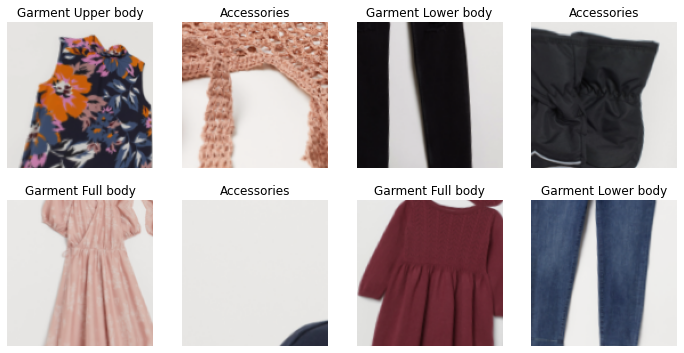

In [34]:
dls.train.show_batch(ncols=4, nrows=2)


In [43]:
metrics = [error_rate, F1Score(axis=-1, labels=None, pos_label=1, average='weighted')]
learn = vision_learner(dls, resnet18, metrics=metrics)
learn.fine_tune(10)


epoch,train_loss,valid_loss,error_rate,f1_score,time
0,2.106446,1.129493,0.375000,0.617536,00:05


epoch,train_loss,valid_loss,error_rate,f1_score,time
0,1.325125,0.820751,0.275000,0.724067,00:05
1,1.216853,0.730433,0.225000,0.774600,00:05
2,1.099955,0.796826,0.231250,0.767527,00:05
3,1.071821,0.749668,0.218750,0.779074,00:05
4,0.993468,0.822836,0.281250,0.719257,00:05
5,0.905492,0.714519,0.237500,0.761843,00:05
6,0.824293,0.660113,0.206250,0.792532,00:05
7,0.753999,0.639308,0.200000,0.799912,00:05
8,0.719872,0.621317,0.193750,0.805271,00:05
9,0.688681,0.626872,0.206250,0.793903,00:05


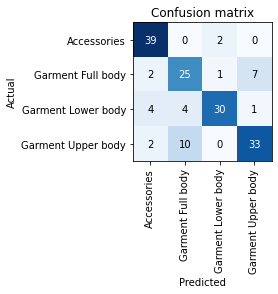

In [44]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


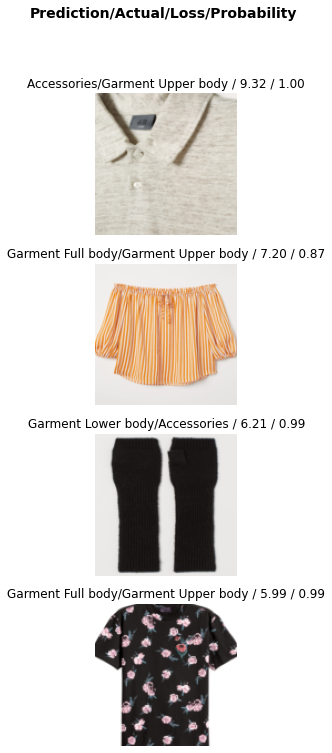

In [46]:
interp.plot_top_losses(4, nrows=4)


In [49]:
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
    def hook_fn(self, module, input, output): 
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
    def remove(self): 
        self.hook.remove()

In [53]:
sf = SaveFeatures(learn.model[1][4])

In [54]:
_= learn.get_preds(data_big.train_ds)
_= learn.get_preds(DatasetType.Valid)

NameError: name 'data_big' is not defined